epoch: 629	 route: [13, 5, 3, 2, 4, 6, 9, 7, 12, 10, 11, 14, 15, 8, 1]	 distance: 31.50	 energy: 41.02


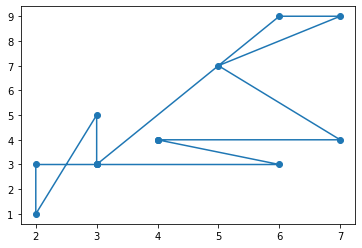

epoch: 1701	 route: [8, 2, 4, 6, 9, 12, 10, 7, 11, 5, 15, 14, 3, 13, 1]	 distance: 27.91	 energy: 27.40


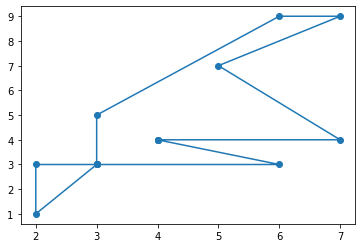

epoch: 2586	 route: [6, 2, 4, 9, 7, 12, 10, 11, 5, 15, 14, 1, 3, 13, 8]	 distance: 26.54	 energy: 42.57


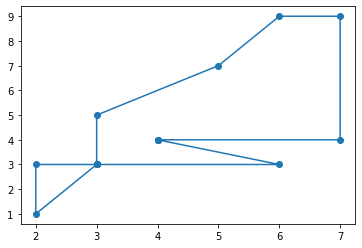

epoch: 6634	 route: [2, 9, 11, 10, 7, 12, 15, 14, 13, 5, 1, 3, 8, 6, 4]	 distance: 24.01	 energy: 27.38


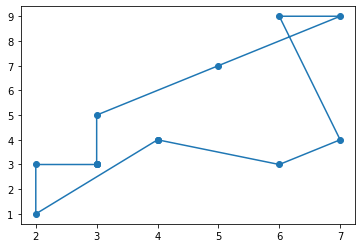

epoch: 6750	 route: [4, 9, 11, 10, 7, 12, 15, 14, 13, 5, 1, 3, 8, 6, 2]	 distance: 23.32	 energy: 27.35


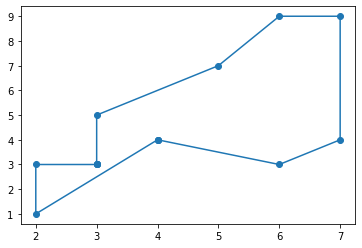

epoch: 10184	 route: [9, 11, 12, 10, 7, 15, 14, 3, 13, 5, 1, 8, 6, 2, 4]	 distance: 23.32	 energy: 27.35


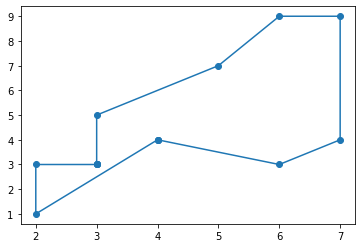

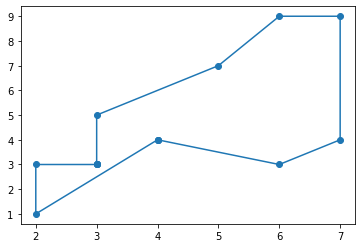

In [1]:
import numpy as np
from matplotlib import pyplot as plt
class Hopfield():
    def __init__(self, step, A, D, U0, T, N):
        self.step = step  #设置学习率
        self.A = A
        self.D = D
        self.N = N
        self.U0 = U0  #神经元初始状态
        self.T = T  #循环次数
 
    def init_U(self, distance):   #初始化神经元状态
        primeU0 = 0.5 * self.U0 * np.log(distance.shape[0] - 1)
        return primeU0 + 2 * (np.random.random(distance.shape)) - 1
 
    def cal_dU(self, V, distance):
        t1 = np.tile(np.sum(V, axis=0, keepdims=True) - 1.0, (V.shape[0], 1))  #tile为平铺  sum按行相加  keepdims为保持矩阵二维特性
        #上式将V神经元输出矩阵每列相加,并将所得矩阵沿着y轴平铺V.shape[0]倍，沿着x轴平铺1倍
        t2 = np.tile(np.sum(V, axis=1, keepdims=True) - 1.0, (1, V.shape[0]))
        #上式将V神经元输出矩阵每行相加，并将所得矩阵沿着y轴平铺V.shape[0]倍，沿着x轴平铺1倍
        primeV = np.hstack([V[:, 1:], V[:, 0:1]])#遍历0维元素
        #该行为将第一列放到矩阵得最后一列
        t3 = np.matmul(distance, primeV)  #矩阵乘法
        return -1 * (self.A * (t1 + t2) + self.D * t3)
 
    def update_U(self, U, dU):
        return U + self.step * dU
 
    def cal_V(self, U):   #计算V
        return 0.5 * (1 + np.tanh(U / self.U0))
 
    def cal_E(self, V, distance):
        t1 = np.sum(np.sum(V, axis=0) ** 2)
        t2 = np.sum(np.sum(V, axis=1) ** 2)
        primeV = np.hstack([V[:, 1:], V[:, 0:1]])
        t3 = np.matmul(distance, primeV) * V
        return 0.5 * (self.A * (t1 + t2) + self.D * np.sum(t3))
 
    def get_path(self, V):
        route = []
        N = V.shape[0]
        for i in range(N):
            mm = np.max(V[:, i])
            for j in range(N):
                if V[j, i] == mm:
                    route += [j]
                    break
        return route
 
    def cal_distance(self, route, distance):
        dis = 0
        for i in range(len(route)):
            dis += distance[route[i], route[(i + 1) % len(route)]]
        return dis
 
 
    def initCities(self):
        xs = np.array([3,6,3,7,3,5,4,3,7,4,6,4,3,2,2])  #通过本函数可以返回一个或一组服从“0~1”均匀分布的随机样本值。随机样本取值范围是[0, 1)，不包括1。
        ys = np.array([3,9,3,9,3,7,4,5,4,4,3,4,3,3,1])  #这里生成N个“0~1”均匀分布的随机样本值
        cities = np.vstack([xs, ys]) #垂直堆叠成2x10的一个矩阵
 
        return cities
 
    def initDis(self, cities):  #返回两两城市间的距离的数组
        N = cities.shape[1]     #shape可以读取矩阵维度，[0]第1维度 ，[1]第二维度
        dis = np.zeros((N, N))  #zeros生成了10x10的矩阵
        for i in range(N):
            for j in range(N):
                dis[i, j] = np.sqrt(np.sum((cities[:, i] - cities[:, j]) ** 2))  #":"代表先是从第0个维度开始获取值到最后一个,取其维度的第i个
        return dis
 
        # print(self.dis)
 
    def test(self): 
        cities = self.initCities()   #生成了城市的坐标数组的数组
        dis = self.initDis(cities)   #返回两两城市间的距离
 
        distance = 0.5 * dis / np.max(dis)   #距离归1化
 
        U = self.init_U(distance)   #初始化神经元状态
        V = self.cal_V(U)  #计算一次神经元输出
        best_route = []
        best_length = 1e+100  #初始化最佳路径长度
        plt.ion()   # 打开交互模式
        plt.figure()  #创建一个画板
        for i in range(self.T):
            dU = self.cal_dU(V, distance)   #dU就是修正权值
            U = self.update_U(U, dU)   #更新神经元状态
            V = self.cal_V(U)       #计算神经元输出
            V = np.round(V)     #四舍五入，变为0或者1
            E = self.cal_E(V, distance)
            route = self.get_path(V)
            # print(route)
            if len(np.unique(route)) == len(route):
                length = self.cal_distance(route, dis)
                if length < best_length:
                    best_length = length
                    best_route = route
                    best_E = E
                    print("epoch: {:d}\t route: {}\t distance: {:.2f}\t energy: {:.2f}".format(i, (
                                np.array(route) + 1).tolist(), best_length, E))
 
                    plt.clf()
                    plt.scatter(cities[0], cities[1])
                    sp = cities[0, best_route + [best_route[0]]]
                    ep = cities[1, best_route + [best_route[0]]]
                    plt.plot(sp, ep)
                    plt.show()
                    plt.pause(0.01)
        if best_length < 1e+100:
            plt.clf()
            plt.ioff()
            plt.scatter(cities[0], cities[1])
            sp = cities[0, best_route + [best_route[0]]]
            ep = cities[1, best_route + [best_route[0]]]
            plt.plot(sp, ep)
            plt.show()
 
 
if __name__ == "__main__":
    hopfield = Hopfield(0.05, 1.5, 0.5, 0.02, 50000, 15)
    hopfield.test()